# Orbit Determination
#### Position and velocity are estimated as well as the drag coefficient using an Unscented Kalman Filter from GPS NMEA measurements

In [1]:
""" If you are using this notebook locally, use the following methods to configure your credentials. """
# from fds.config import set_client_id, set_client_secret
# set_client_id('CLIENT_ID')
# set_client_secret('CLIENT_SECRET')

In [2]:
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
from fds.models.determination.configuration import OrbitDeterminationConfiguration
from fds.models.determination.requests import DragCoefficientEstimationRequest
from fds.models.determination.use_case import OrbitDetermination
from fds.models.orbital_state import PropagationContext, CovarianceMatrix, OrbitalState
from fds.models.spacecraft import SpacecraftSphere
from fds.models.telemetry import TelemetryGpsNmea
from fds.models.two_line_element import TwoLineElement
from fds.utils.frames import Frame

## Prepare NMEA measurements
##### For more information on the GPS NMEA standard https://aprs.gids.nl/nmea/

In [3]:
# Latitude [deg], longitude [deg], ground speed [km/s], altitude [m], geoid ondulation [m] (identically zero in this example)
nmea_measurements = [[31.945420, -126.505682,  7367.186584,  412375.054104,  0.0],
                     [29.240459, -123.511077,  7367.967736,  411821.061405,  0.0],
                     [26.459760, -120.684592,  7368.693042,  411299.690655,  0.0],
                     [23.614870, -118.003847,  7369.338715,  410835.315955,  0.0],
                     [20.715957, -115.447822,  7369.897444,  410442.560347,  0.0],
                     [17.772044, -112.997251,  7370.349873,  410156.920987,  0.0],
                     [14.791415, -110.634067,  7370.681081,  409921.752804,  0.0],
                     [11.781282, -108.341590,  7370.888166,  409812.978649,  0.0],
                     [8.748428,  -106.104106,   7370.954765,  409828.677953, 0.0],
                     [5.699253,  -103.906705,   7370.876706,  409916.755493, 0.0],
                     [2.639727,  -101.735212,   7370.647704,  410136.202027, 0.0],
                     [-0.424380,  -99.575730,  7370.267061,  410460.341200,  0.0],
                     [-3.487369,  -97.414643,  7369.738987,  410901.281852,  0.0],
                     [-6.543506,  -95.238211,  7369.066255,  411452.304177,  0.0],
                     [-9.586998,  -93.032651,  7368.253201,  412118.385775,  0.0]]

# UTC dates corresponding to the measurements
dates_ts = ["2024-05-21T08:24:02.699136",
            "2024-05-21T08:25:02.699136",
            "2024-05-21T08:26:02.699136",
            "2024-05-21T08:27:02.699136",
            "2024-05-21T08:28:02.699136",
            "2024-05-21T08:29:02.699136",
            "2024-05-21T08:30:02.699136",
            "2024-05-21T08:31:02.699136",
            "2024-05-21T08:32:02.699136",
            "2024-05-21T08:33:02.699136",
            "2024-05-21T08:34:02.699136",
            "2024-05-21T08:35:02.699136",
            "2024-05-21T08:36:02.699136",
            "2024-05-21T08:37:02.699136",
            "2024-05-21T08:38:02.699136"]

dates = [datetime.fromisoformat(ts).strftime("%Y-%m-%dT%H:%M:%S.%fZ") for ts in dates_ts]

telemetry_nmea = TelemetryGpsNmea(
    measurements=nmea_measurements,
    dates=dates,
    standard_deviation_altitude=200,
    standard_deviation_ground_speed=5,
    standard_deviation_latitude=0.002,
    standard_deviation_longitude=0.002
)

propagation_context = PropagationContext(
    model_perturbations=[
        PropagationContext.Perturbation.DRAG,
        PropagationContext.Perturbation.EARTH_POTENTIAL,
        PropagationContext.Perturbation.SRP,
        PropagationContext.Perturbation.THIRD_BODY,
    ],
    model_solar_flux=150,  # SFU
    model_earth_potential_deg=30,
    model_earth_potential_ord=30,
    model_atmosphere_kind=PropagationContext.AtmosphereModel.HARRIS_PRIESTER,
    integrator_kind=PropagationContext.IntegratorKind.DORMAND_PRINCE_853,
    integrator_min_step=0.01,  # s
    integrator_max_step=100,  # s
)

spacecraft = SpacecraftSphere(
    platform_mass=112,  # kg
    drag_coefficient=2.2,
    cross_section=0.785,
    reflectivity_coefficient=0.6,
)

covariance = CovarianceMatrix.from_diagonal(
    diagonal=(100, 100, 100, 0.1, 0.1, 0.1),
    frame=Frame.TNW
)

process_noise_matrix = CovarianceMatrix.from_diagonal(
    diagonal=(1E-1, 1E-1, 1E-1, 1E-4, 1E-4, 1E-4),
    
    frame=Frame.TNW)

od_config = OrbitDeterminationConfiguration(
    tuning_alpha=0.5,  # Defines the spread of the sigma points. Typical values from 1E-4 to 1E-1.
    tuning_beta=2,  # Beta = 2 is optimal for Gaussian distributions.
    tuning_kappa=-2,  # Defines the spread of the sigma points. Typical values from 1 to 10.
    outliers_manager_scale=10,  #
    outliers_manager_warmup=0,  #
    noise_provider_kind=OrbitDeterminationConfiguration.NoiseProviderKind.BASIC,
    process_noise_matrix=process_noise_matrix,
)

drag_estimation = DragCoefficientEstimationRequest(
    standard_deviation=0.01,
    process_noise_standard_deviation=1E-2,
)

# Initial TLE
initial_tle = TwoLineElement("1 25544U 98067A   24142.35003124  .00022843  00000-0  38371-3 0  9995",
                             "2 25544  51.6390  88.3709 0003333 191.4959 306.2513 15.51667899454382")

initial_orbital_state = OrbitalState.from_tle(
    tle=initial_tle,
    covariance_matrix=covariance,
    propagation_context=propagation_context,
    spacecraft=spacecraft
)

## Run the use case

In [4]:
od_tle = OrbitDetermination(
    initial_orbital_state=initial_orbital_state,
    telemetry=telemetry_nmea,
    configuration=od_config,
    parameter_estimation_requests=[drag_estimation]
)

od_tle.run()

results = od_tle.result

## Processing the results
##### Define auxiliary functions used to plot the results

In [5]:
COE_KEYS = ["SMA", "ECC", "INC", "RAAN", "AOP", "TA"]
UNITS    = ["km", "", "deg", "deg", "deg", "deg"]


def extract_orbital_elements_from_orbit_list(keplerian_orbiti_list):
    return {
        COE_KEYS[0]: [keplerian_orbit.orbital_elements.SMA for keplerian_orbit in keplerian_orbiti_list],
        COE_KEYS[1]: [keplerian_orbit.orbital_elements.ECC for keplerian_orbit in keplerian_orbiti_list],
        COE_KEYS[2]: [keplerian_orbit.orbital_elements.INC for keplerian_orbit in keplerian_orbiti_list],
        COE_KEYS[3]: [keplerian_orbit.orbital_elements.RAAN for keplerian_orbit in keplerian_orbiti_list],
        COE_KEYS[4]: [keplerian_orbit.orbital_elements.AOP for keplerian_orbit in keplerian_orbiti_list],
        COE_KEYS[5]: [keplerian_orbit.orbital_elements.TA for keplerian_orbit in keplerian_orbiti_list]
    }


def plot_keplerian_element(dates_list, rel_times, osculating_states, mean_states, element, title):
    plt.figure()
    plt.plot(rel_times, osculating_states[element], 'o', label="Osculating")
    plt.plot(rel_times, mean_states[element], 'o', label="Mean")
    plt.grid()
    plt.title(title)
    plt.xlabel(f"Time [h] since {dates_list[0]}")
    plt.ylabel(f"{title} [{UNITS[COE_KEYS.index(element)]}]")
    plt.legend()
    plt.show()


def plot_residuals(dates_list, rel_times, residuals_statistics):
    n_subplots = 4
    fig, axs = plt.subplots(n_subplots, 1, sharex=True)
    for i, (_k, _v) in enumerate(zip(["altitude", "ground_speed", "latitude", "longitude"], 
                   [residual_statistics.altitude, residual_statistics.ground_speed,
                    residual_statistics.latitude, residual_statistics.longitude])):
        axs[i].plot(rel_times, _v.values, label='Residuals')
        # Add a red dashed line at 3 and -3
        axs[i].axhline(y=3, color='r', linestyle='--', label=r'$\pm3$')
        axs[i].axhline(y=-3, color='r', linestyle='--')
        axs[i].set_ylabel(_k)
    axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.suptitle("Normalized Residuals")
    plt.xlabel(f"Time [h] since {dates_list[0]}")
    fig.tight_layout()
    plt.show()


##### Plot estimated Keplerian orbital elements, osculating and mean

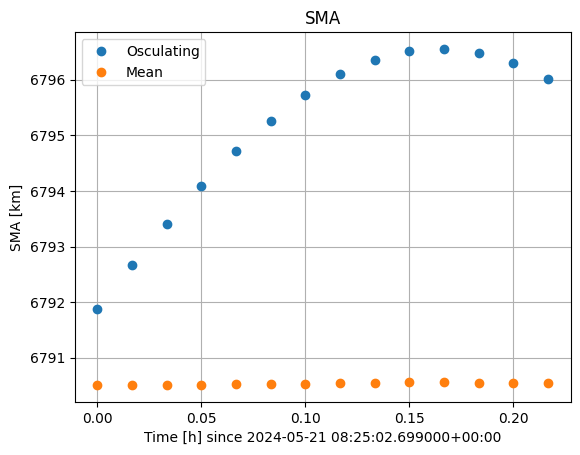

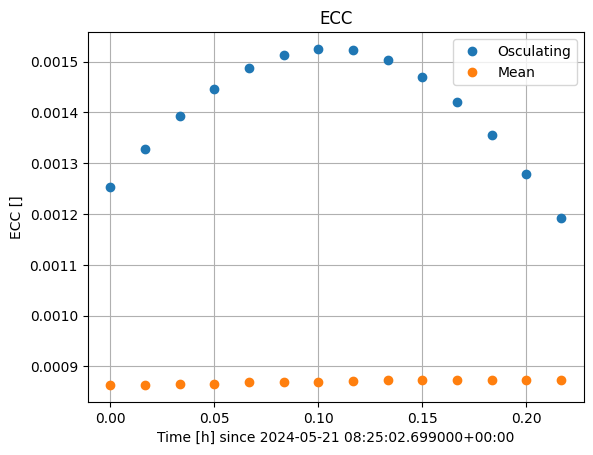

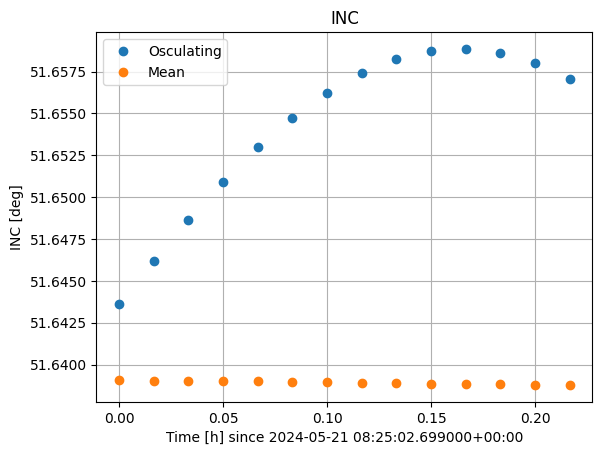

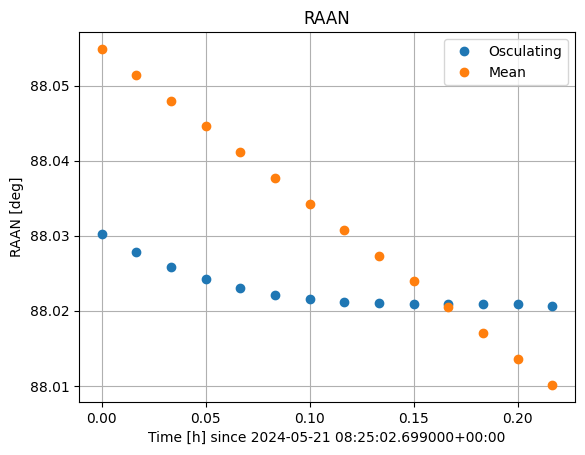

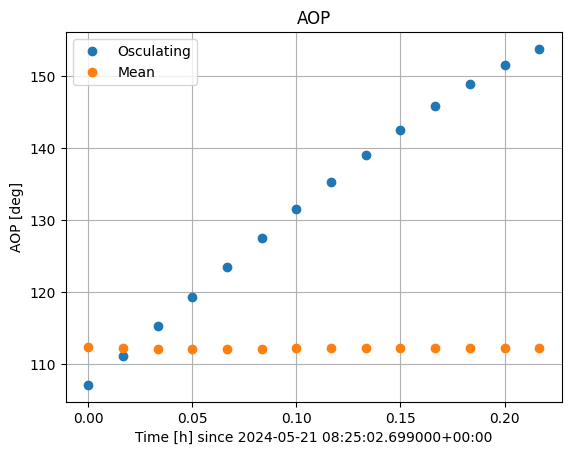

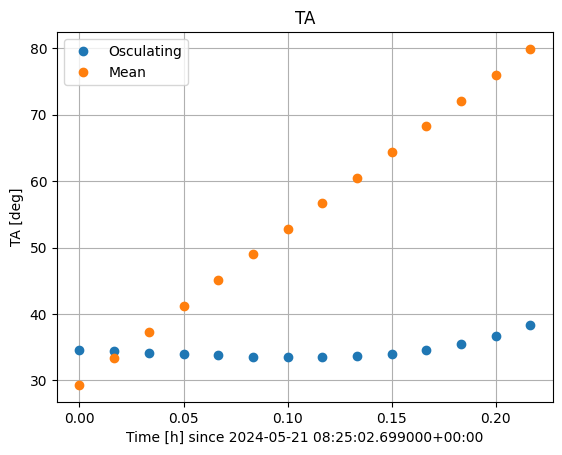

In [9]:
dates = results.in_depth_results.dates
relative_times = [(date - dates[0]).total_seconds() / 3600 for date in dates]
estimated_osc_states = extract_orbital_elements_from_orbit_list(results.in_depth_results.osculating_orbits)
estimated_mean_states = extract_orbital_elements_from_orbit_list(results.in_depth_results.mean_orbits)

for el in COE_KEYS:
    plot_keplerian_element(dates, relative_times, estimated_osc_states, estimated_mean_states,
                           el, el)

##### Plot the normalized residuals

In [8]:
# Create a table with the residuals statistics (mean, median etc)
residual_statistics = results.report.residuals_statistics
columns = ["Parameter", "Mean", "Median", "Std", "Max", "Min"]
data = []
for name, v in zip(["altitude", "ground_speed", "latitude", "longitude"], 
                   [residual_statistics.altitude, residual_statistics.ground_speed,
                    residual_statistics.latitude, residual_statistics.longitude]):
    data.append([name, v.mean, v.median, v.standard_deviation, v.max, v.min])

residual_statistics_df = pd.DataFrame(data, columns=columns)
print("Normalized residuals statistics")
residual_statistics_df

Normalized residuals statistics


,Parameter,Mean,Median,Std,Max,Min
0,altitude,0.003169,0.009398,0.037151,0.060793,-0.062284
1,ground_speed,0.000265,0.000131,0.000359,0.000817,-0.000241
2,latitude,0.000943,0.000527,0.008443,0.021751,-0.013429
3,longitude,0.000108,0.001820,0.008411,0.014598,-0.017285


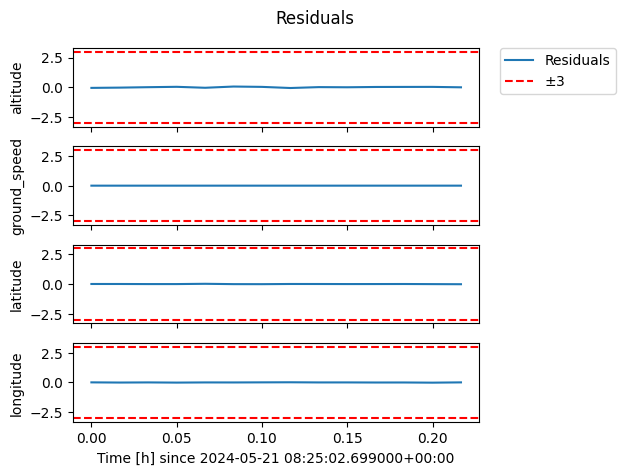

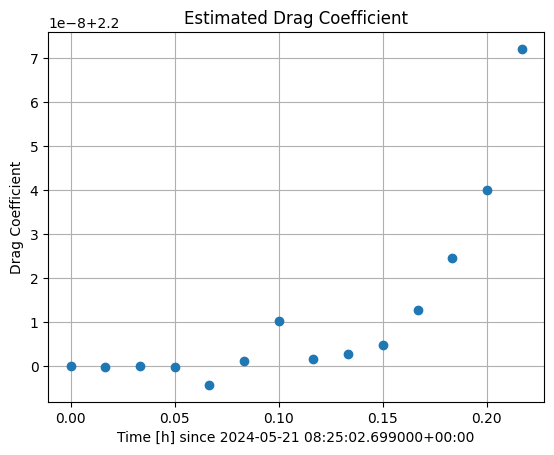

In [ ]:
plot_residuals(dates, relative_times, results.report.residuals_statistics)

# Plot estimated Drag
plt.figure()
plt.plot(relative_times, [elem.value for elem in results.in_depth_results.estimated_drag_coefficients], 'o')
plt.grid()
plt.title("Estimated Drag Coefficient")
plt.xlabel(f"Time [h] since {dates[0]}")
plt.ylabel("Drag Coefficient")

plt.show()